In [37]:
!pip install kaggle
# Upload kaggle.json (API key)
from google.colab import files
files.upload()  # Upload your kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
!unzip gtsrb-german-traffic-sign.zip -d gtsrb


Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
gtsrb-german-traffic-sign.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  gtsrb-german-traffic-sign.zip
replace gtsrb/Meta.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [38]:
!ls gtsrb

meta  Meta  Meta.csv  test  Test  Test.csv  train  Train  Train.csv


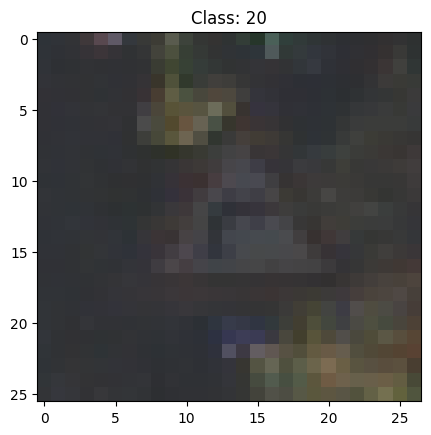

In [39]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
df = pd.read_csv('gtsrb/Train.csv')
img = cv2.imread('gtsrb/' + df['Path'][0])  # Load first image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
plt.title(f"Class: {df['ClassId'][0]}")
plt.show()

**preprocess the data**


> Add blockquote



In [40]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd

def load_images(df, base_path='gtsrb/'):
    images = []
    labels = []
    for _, row in df.iterrows():
        img = cv2.imread(base_path + row['Path'])
        if img is None:  # Skip invalid images
            continue
        img = cv2.resize(img, (32, 32)) / 255.0
        images.append(img)
        labels.append(row['ClassId'])
    return np.array(images), np.array(labels)

# Load and filter dataset (use 5 classes)
df = pd.read_csv('gtsrb/Train.csv')
df = df[df['ClassId'].isin([0, 1, 2, 3, 4])]  # Select 5 classes
X, y = load_images(df)
y = tf.keras.utils.to_categorical(y, num_classes=5)  # Update num_classes to 5
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1)
datagen.fit(X_train)

# Verify shapes
print(X_train.shape, y_train.shape)

(6456, 32, 32, 3) (6456, 5)


# **Build the CNN**

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')  # Update to 5 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,165 (1.36 MB)

 Trainable params: 356,165 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

# **train the model**

In [43]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=20, validation_data=(X_val, y_val))
model.save('traffic_sign_model.h5')

Epoch 1/20
 50/202 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.7287 - loss: 0.7244

KeyboardInterrupt: 

# **Visualize Traning Result**

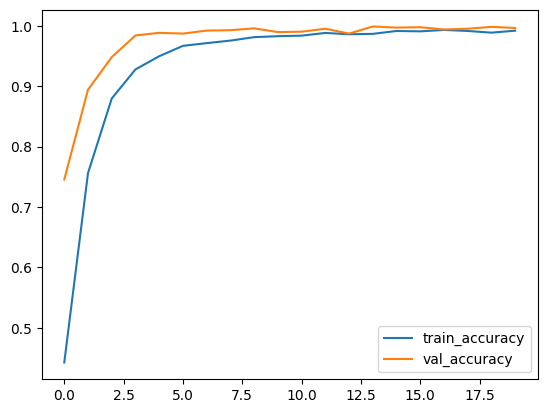

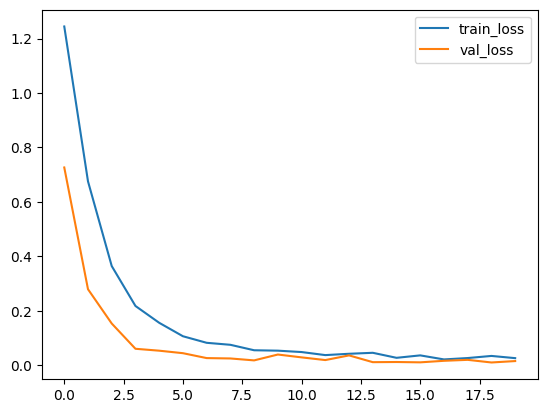

In [44]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# **Test Model On Images**

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('traffic_sign_model.h5')

# Load and preprocess test data (same 5 classes)
def load_images(df, base_path='gtsrb/'):
    images = []
    labels = []
    for _, row in df.iterrows():
        img = cv2.imread(base_path + row['Path'])
        if img is None:
            continue
        img = cv2.resize(img, (32, 32)) / 255.0
        images.append(img)
        labels.append(row['ClassId'])
    return np.array(images), np.array(labels)

test_df = pd.read_csv('gtsrb/Test.csv')
test_df = test_df[test_df['ClassId'].isin([0, 1, 2, 3, 4])]  # Filter for 5 classes
X_test, y_test = load_images(test_df)

# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = y_test  # Already integers (0–4)
print(f"Test Accuracy: {accuracy_score(y_test_classes, y_pred_classes)}")

# Visualize 5 predictions
for i in range(5):
    plt.imshow(X_test[i])
    plt.title(f"Pred: {y_pred_classes[i]}, True: {y_test_classes[i]}")
    plt.axis('off')
    plt.show()

# **Real time detection**
upload a sample video

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!ls

**visualize predictions in frames**

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the model and recompile
try:
    model = load_model('traffic_sign_model.h5')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print("Model loaded successfully.")
except Exception as e:
    print("Error loading model:", e)
    raise

# Class names for visualization (based on GTSRB classes 0–4)
class_names = {0: 'Speed Limit 20', 1: 'Speed Limit 30', 2: 'Speed Limit 50', 3: 'Speed Limit 60', 4: 'Speed Limit 70'}

# Load video
video_path = '12950311-hd_1080_1920_30fps (2).mp4'
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Could not open video file:", video_path)
    raise FileNotFoundError("Video file not found or unsupported.")

# Get video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Video properties - Width: {width}, Height: {height}, FPS: {fps}, Total Frames: {total_frames}")

frame_count = 0
max_frames = 5

while cap.isOpened() and frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read frame. Frame count:", frame_count)
        break
    try:
        print(f"Processing frame {frame_count + 1}/{max_frames}")
        # Preprocess frame
        img = cv2.resize(frame, (32, 32)) / 255.0
        img = np.expand_dims(img, axis=0)
        pred = model.predict(img)
        pred_class = np.argmax(pred, axis=1)[0]
        confidence = np.max(pred)
        # Draw prediction
        label = f"{class_names[pred_class]} ({confidence:.2f})"
        cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        # Display frame
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(label)
        plt.axis('off')
        plt.show()
        frame_count += 1
    except Exception as e:
        print("Error processing frame:", e)
        break

cap.release()
print("Total frames processed:", frame_count)

**video output**

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the model and recompile
model = load_model('traffic_sign_model.h5')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Class names for visualization (based on GTSRB classes 0–4)
class_names = {0: 'Speed Limit 20', 1: 'Speed Limit 30', 2: 'Speed Limit 50', 3: 'Speed Limit 60', 4: 'Speed Limit 70'}

# Load video
video_path = '12950311-hd_1080_1920_30fps (2).mp4'
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Could not open video file:", video_path)
    raise FileNotFoundError("Video file not found or unsupported.")

# Get video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
print(f"Video properties - Width: {width}, Height: {height}, FPS: {fps}")

# Create output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_new.mp4', fourcc, fps, (width, height))

frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    # Preprocess frame
    img = cv2.resize(frame, (32, 32)) / 255.0
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    pred_class = np.argmax(pred, axis=1)[0]
    confidence = np.max(pred)
    # Draw prediction
    label = f"{class_names[pred_class]} ({confidence:.2f})"
    cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    out.write(frame)
    frame_count += 1
    if frame_count % 50 == 0:
        print(f"Processed {frame_count} frames")

cap.release()
out.release()
print("Total frames processed:", frame_count)

# Download the output video
from google.colab import files
files.download('output_new.mp4')